# Anomaly detection using AutoEncoders

In [3]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, datasets

In [14]:
# Load data from MNIST dataset - a dataset of handwritten digits
(train_dataset, _), (test_dataset, _) = datasets.mnist.load_data()

# Convert the data type of datasets
train_dataset = train_dataset.astype('float32') / 256
test_dataset = test_dataset.astype('float32') / 256

# Reshape the dataset
# reshape function signature: reshape(number of samples, height, width, channels)
# number of samples = 6k
# image dimension = 28x28
# channels = 1 (grayscale images; 3 for RGB) 
train_dataset = train_dataset.reshape(train_dataset.shape[0], 28, 28, 1)
test_dataset = test_dataset.reshape(test_dataset.shape[0], 28, 28, 1)

(60000, 28, 28)
<class 'numpy.ndarray'>


In [16]:
# Define model architecture
input_shape = (28,28,1)
latent_dim = 32

In [18]:
# Encoder 
# Transforms input data into a latent space (bottleneck or compressed) representation
# Convolutional layer is used to extract and capture spatial features from input data (images)
# MaxPooling layer is used for downsampling and reducing the spatial dimensions while retaining important features
# After applying convolutional and pooling layers for feature extraction, the output is flattened using layers.Flatten
# Dense  layers - transforms extracted features into a smaller, compressed representation (latent space) using the latent_dim
encoder =  models.Sequential([
    layers.Input(shape=input_shape),
    # Conv2D(filters=dim of output space, kernel_size of convolution window, activation, padding)
    layers.Conv2D(16, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Conv2D(8, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2), padding='same'),
    layers.Flatten(), #  transforms multi-dimensional array into a one-dimensional array
    layers.Dense(latent_dim, activation='relu')
])

# Decoder 
# reconstructs the original input from the latent space representation
# Conv2DTranspose layer does the inverse operation to the Conv2D layer
decoder = models.Sequential([
    layers.Input(shape=(latent_dim,)),
    layers.Dense(392, activation='relu'),
    layers.Reshape((7,7,8)),
    layers.Conv2DTranspose(8, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2DTranspose(16, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),
    layers.Conv2DTranspose(1,(3,3), activation='sigmoid', padding='same')
])

# Combine Encoder and Decoder
autoencoder = models.Sequential([encoder, decoder])

# Compile the model, specifying the loss function and optimization method  
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [19]:
# Training the autoencoder
autoencoder.fit(train_dataset, train_dataset, epochs=10, batch_size=128, shuffle=True, validation_data=(test_dataset, test_dataset))

Epoch 1/10
469/469 [==============================] - 28s 56ms/step - loss: 0.2105 - val_loss: 0.1256
Epoch 2/10
469/469 [==============================] - 26s 56ms/step - loss: 0.1177 - val_loss: 0.1100
Epoch 3/10
469/469 [==============================] - 31s 67ms/step - loss: 0.1075 - val_loss: 0.1031
Epoch 4/10
469/469 [==============================] - 29s 62ms/step - loss: 0.1026 - val_loss: 0.0995
Epoch 5/10
469/469 [==============================] - 28s 60ms/step - loss: 0.0996 - val_loss: 0.0969
Epoch 6/10
469/469 [==============================] - 28s 60ms/step - loss: 0.0972 - val_loss: 0.0948
Epoch 7/10
469/469 [==============================] - 29s 62ms/step - loss: 0.0954 - val_loss: 0.0935
Epoch 8/10
469/469 [==============================] - 30s 64ms/step - loss: 0.0941 - val_loss: 0.0923
Epoch 9/10
469/469 [==============================] - 29s 63ms/step - loss: 0.0930 - val_loss: 0.0912
Epoch 10/10
469/469 [==============================] - 29s 63ms/step - loss: 0.092

In [23]:
# test reconstructed images using test_dataset
reconstructed_imgs = autoencoder.predict(test_dataset)

# compute reconstruction errors
mse = np.mean(np.square(test_dataset - reconstructed_imgs),axis=(1,2,3))

# set threshold
threshold = np.mean(mse) + 2 * np.std(mse)

# Print threshold
print(f"Reconstruction error threshold {threshold}")

313/313 [==============================] - 2s 7ms/step
Reconstruction error threshold 0.019551760517060757


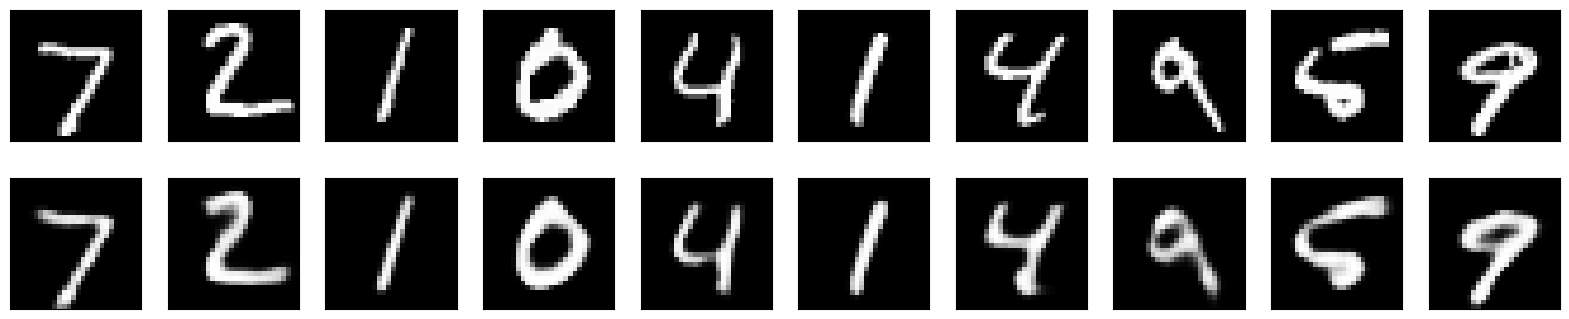

In [22]:
# Plot some test data and their representation
n = 10
plt.figure(figsize=(20,4))
for i in range(n):
    # Display Original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_dataset[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Reconstructed Image
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_imgs[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [24]:
# Identify anomalies using the threshold
anomalies = np.where(mse > threshold)[0]
print(f"Anomalies detected: {len(anomalies)}")
print(f"Indices of anomalies: {anomalies}")

Anomalies detected: 378
Indices of anomalies: [  18   54   72   87   95  149  151  245  247  268  290  341  366  391
  402  425  431  527  528  543  596  629  631  655  717  744  787  810
  841  844  856  876  895  926  975  991 1017 1028 1044 1074 1118 1125
 1156 1170 1178 1187 1198 1202 1248 1281 1325 1364 1395 1438 1464 1499
 1506 1509 1526 1549 1609 1610 1663 1682 1737 1754 1758 1782 1882 1930
 1941 1960 1969 1984 2004 2009 2093 2099 2118 2145 2179 2222 2224 2229
 2247 2272 2291 2298 2325 2350 2371 2422 2425 2436 2488 2535 2574 2597
 2621 2667 2697 2702 2711 2774 2802 2864 2881 2929 2970 2975 3030 3033
 3037 3069 3073 3122 3198 3205 3206 3222 3239 3260 3263 3269 3284 3290
 3295 3364 3394 3416 3456 3474 3534 3542 3543 3555 3559 3567 3575 3576
 3583 3604 3627 3665 3674 3683 3705 3708 3727 3749 3757 3767 3774 3778
 3782 3813 3817 3820 3829 3835 3846 3893 3901 3921 3932 3951 3958 3963
 4018 4041 4065 4086 4112 4117 4123 4140 4187 4193 4230 4253 4341 4343
 4374 4439 4444 4449 4463 4499 